### Jigsaw Puzzle Self Supervised Learning Task

In [1]:
# Data set for all 6 camera views
# How to perform permutation from a fixed set (assign permutation number)
# Architecture and prediction scheme

### Dataset Creation for Self Supervised Task 2: Jigsaw Puzzle

In [12]:
import os
import random

from PIL import Image
import itertools

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models

In [126]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [127]:
# Constants taken from data_helper.py
NUM_SAMPLE_PER_SCENE = 126
NUM_IMAGE_PER_SAMPLE = 6
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

# Unlabeled scenes
val_unlabeled_scene_index = np.arange(80,106)
train_unlabeled_scene_index = np.arange(80)


# Image folder
image_folder = '/scratch/brs426/data'

# Transforms
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
normalize = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize((0.5565, 0.6024, 0.6324), (0.3353, 0.3378, 0.3389))])

# Also need to include normalization for color channels and cropping
# Cropping should be done up to [:,:175,:] for all views

# Normalization for patches:
# Mean: [0.5206, 0.5748, 0.6066]
# STD: [0.3140, 0.3253, 0.3349]

# Normalization for entire image
# Mean: [0.5565, 0.6024, 0.6324]
# STD: [0.3353, 0.3378, 0.3389]

In [128]:
# Permutations to restrict difficulty of problem
permutations = list(itertools.permutations(range(6)))

class JigsawDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, scene_index, transform, permutations):
        """
        Args:
            image_folder (string): the location of the image folder
            scene_index (list): a list of scene indices for the unlabeled data 
            first_dim ({'sample', 'image'}):
                'sample' will return [batch_size, NUM_IMAGE_PER_SAMPLE, 3, H, W]
                'image' will return [batch_size, 3, H, W] and the index of the camera [0 - 5]
                    CAM_FRONT_LEFT: 0
                    CAM_FRONT: 1
                    CAM_FRONT_RIGHT: 2
                    CAM_BACK_LEFT: 3
                    CAM_BACK.jpeg: 4
                    CAM_BACK_RIGHT: 5
            transform (Transform): The function to process the image
        """

        self.image_folder = image_folder
        self.scene_index = scene_index
        self.transform = transform
        self.permutations = permutations

        assert first_dim in ['sample', 'image']
        self.first_dim = first_dim

    def __len__(self):
        return self.scene_index.size * NUM_SAMPLE_PER_SCENE

    
    def __getitem__(self, index):
        scene_id = self.scene_index[index // NUM_SAMPLE_PER_SCENE]
        sample_id = index % NUM_SAMPLE_PER_SCENE
        sample_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}') 

        images = []
        for image_name in image_names:
            image_path = os.path.join(sample_path, image_name)
            image = Image.open(image_path)
            images.append(self.transform(image))
        image_tensor = torch.stack(images)
        
        # Sample permutation
        idx = random.randint(0, len(self.permutations) - 1)
        permutation = list(self.permutations[idx])
        image_tensor = image_tensor[permutation, :, :, :]
        

        return image_tensor, idx

In [129]:
jigsaw_train = JigsawDataset(image_folder, train_unlabeled_scene_index, normalize, permutations)
jigsaw_val = JigsawDataset(image_folder, val_unlabeled_scene_index, normalize, permutations)

In [130]:
jigsaw_train_loader = torch.utils.data.DataLoader(jigsaw_train, batch_size=12, shuffle=True, num_workers=4)
jigsaw_val_loader = torch.utils.data.DataLoader(jigsaw_val, batch_size=12, shuffle=True, num_workers=4)

### Model Architecture

In [131]:
# Create resnet-based model
# Resnet outputs unnormalized scores for 1000 class classification problem
class ResNet34Model(nn.Module):
    def __init__(self, num_classes, hidden_size):
        super(ResNet34Model, self).__init__()
        self.resnet = models.resnet34()
        self.fc1 = nn.Linear(1000, hidden_size)
        # Mutliply by 6 because we are concatenating the representations for each image together
        self.fc2 = nn.Linear(6 * hidden_size, num_classes)
    
    def forward(self, x):
        # Input x is (Batch x Number of Images x Channels x Height x Width)
        batch = x.shape[0]
        channels = x.shape[2]
        height = x.shape[3]
        width = x.shape[4]
        x = x.reshape(-1, channels, height, width)
        # Now our input is ((Batch x Number of Images) x Channels x Height x Width)
        x = F.relu(self.resnet(x))
        x = F.relu(self.fc1(x))
        # Now we need to recast to have original batch size (should double check this)
        x = x.reshape(batch, -1)
        x = self.fc2(x)
        return x

### Training Logic

In [132]:
# Train logic, return average loss over training set after each epoch
def train(model, device, train_loader, optimizer, epoch, log_interval = 250):
    # Set model to training mode
    model.train()
    
    # Number correct for accuracy
    num_correct = 0
    
    # Train loss
    train_loss = 0
    
    # Loop through examples
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Send data and target to device
        data, target = data.to(device), target.to(device)
        
        # Zero out optimizer
        optimizer.zero_grad()
        
        # Pass data through model
        output = model(data)
        predictions = torch.argmax(output, 1)
        num_correct += torch.sum(predictions == target).item()
        
        # Compute the loss
        loss = F.cross_entropy(output, target)
        train_loss += loss.item()
        
        # Backpropagate loss
        loss.backward()
        
        # Make a step with the optimizer
        optimizer.step()
        
        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    
    # Average train loss
    average_train_loss = train_loss / len(train_loader)
    # Print loss (uncomment lines below once implemented)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        average_train_loss, num_correct, len(train_loader.dataset),
        100. * num_correct / len(train_loader.dataset)))

### Validation Logic

In [133]:
# Define test method
def test(model, device, test_loader):
    # Set model to evaluation mode
    model.eval()
    # Variable for the total loss 
    test_loss = 0
    # Counter for the correct predictions
    num_correct = 0
    
    # don't need autograd for eval
    with torch.no_grad():
        # Loop through data points
        for data, target in test_loader:
            pass # remove once implemented
        
            # Send data to device
            data, target = data.to(device), target.to(device)
            
            # Pass data through model
            output = model(data)
            
            # Compute the negative log likelihood loss with reduction='sum' and add to total test_loss
            loss = F.cross_entropy(output, target, reduction='sum')
            test_loss += loss.item()
            
            # Get predictions from the model for each data point
            predictions = torch.argmax(output, 1)

            # Add number of correct predictions to total num_correct 
            num_correct += torch.sum(predictions == target).item()
            
    
    # Compute the average test_loss
    # avg_test_loss = TODO
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    # Print loss (uncomment lines below once implemented)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, num_correct, len(test_loader.dataset),
        100. * num_correct / len(test_loader.dataset)))
    
    return avg_test_loss

In [134]:
# ResNet model
res34 = ResNet34Model(720, 256).to(device)

# Optimizer
optimizer = optim.Adam(res34.parameters(), lr=3e-4)

In [ ]:
best_val_loss = None
save_path = "./ben_models/resnet34_jigsaw_720_permutations_SSL_checkpoint.p"
epochs = 20
for epoch in range(1, epochs + 1):
    # Train model
    train(res34, device, jigsaw_train_loader, optimizer, epoch)
    val_loss = test(res34, device, jigsaw_val_loader)
    # Save model
    if best_train_loss is None:
        torch.save({'model_state_dict': res34.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': val_loss}, save_path)
        best_val_loss = val_loss

Train Epoch: 1 [0/10080 (0%)]	Loss: 6.565759
Train Epoch: 1 [3000/10080 (30%)]	Loss: 6.592890
Train Epoch: 1 [6000/10080 (60%)]	Loss: 4.447103
Train Epoch: 1 [9000/10080 (89%)]	Loss: 2.912582

Train set: Average loss: 4.9291, Accuracy: 825/10080 (8%)


Test set: Average loss: 2.2707, Accuracy: 806/3276 (25%)

Train Epoch: 2 [0/10080 (0%)]	Loss: 2.311089
Train Epoch: 2 [3000/10080 (30%)]	Loss: 1.789040
Train Epoch: 2 [6000/10080 (60%)]	Loss: 1.014331
Train Epoch: 2 [9000/10080 (89%)]	Loss: 0.236251

Train set: Average loss: 1.2597, Accuracy: 5350/10080 (53%)


Test set: Average loss: 0.3852, Accuracy: 2911/3276 (89%)

Train Epoch: 3 [0/10080 (0%)]	Loss: 0.265000
Train Epoch: 3 [3000/10080 (30%)]	Loss: 0.178473
Train Epoch: 3 [6000/10080 (60%)]	Loss: 0.023386
Train Epoch: 3 [9000/10080 (89%)]	Loss: 0.010338

Train set: Average loss: 0.1342, Accuracy: 9744/10080 (97%)


Test set: Average loss: 0.0401, Accuracy: 3240/3276 (99%)

Train Epoch: 4 [0/10080 (0%)]	Loss: 0.009254
Train Epoch: 4 [

In [73]:
len(jigsaw_loader)

1113

In [37]:
y_hat_reshaped = y_hat.reshape(2, -1)

In [39]:
y_hat_reshaped

tensor([[-0.1213,  0.1138, -0.0850,  0.0614, -0.0618,  0.0530, -0.0622,  0.0600,
         -0.1010,  0.0871, -0.0666,  0.0573],
        [-0.0862,  0.0642, -0.0696,  0.0721, -0.0584,  0.0547, -0.0806,  0.0607,
         -0.0684,  0.0518, -0.1063,  0.0528]], grad_fn=<ViewBackward>)

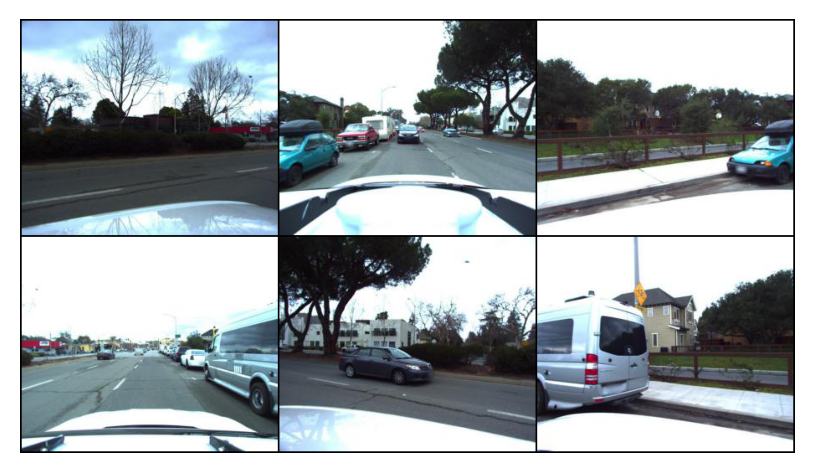

In [17]:
plt.imshow(torchvision.utils.make_grid(sample[0][0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

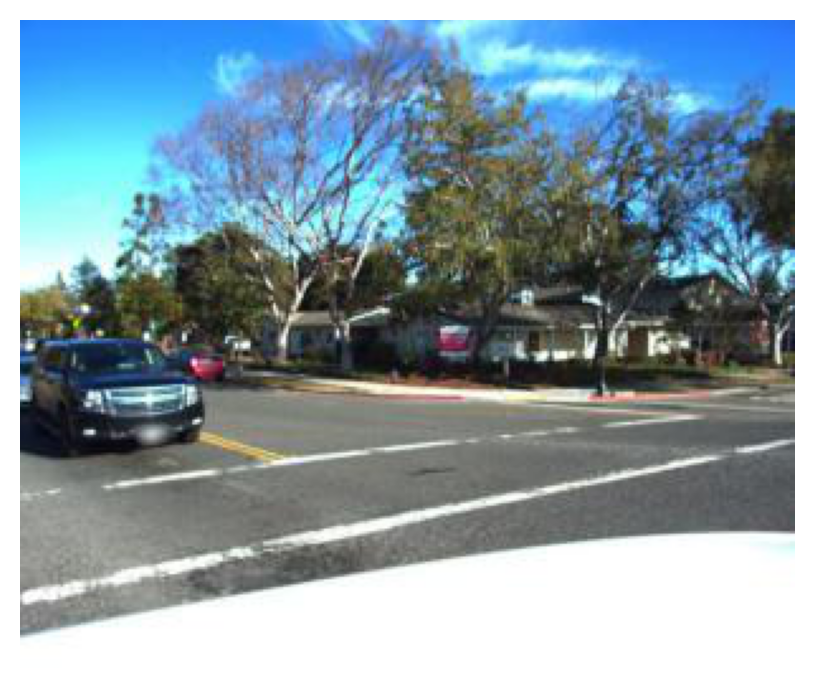

In [27]:
plt.imshow(reshaped_sample[9].numpy().transpose(1, 2, 0))
plt.axis('off');

In [81]:
np.arange(11, 20)

array([11, 12, 13, 14, 15, 16, 17, 18, 19])

In [ ]:
# Define model architecture for jigsaw task
# Use ResNet 34 - feed each image through resnet 34, concatenate vector representations across images
# Feed to final classification layer

In [11]:
!nvidia-smi

Mon Apr 27 13:35:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:85:00.0 Off |                    0 |
| N/A   39C    P0    58W / 250W |   4839MiB / 22919MiB |     88%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [19]:
size=11
res = getattr(models, "resnet{}".format(size))

AttributeError: module 'torchvision.models' has no attribute 'resnet11'

In [18]:
res

<function torchvision.models.resnet.resnet101(pretrained=False, progress=True, **kwargs)>